
# Hollow Glass Ring in Air

N1 in Bird

In [114]:
import numpy as np

from fiberamp.fiber.microstruct.bragg import BraggScalar, Bragg
from step_exact import plotlogf
from ngsolve.webgui import Draw
from ngsolve import CF
from scipy.optimize import newton
from scipy.linalg import null_space

In [118]:
n_air = 1
n_glass = 1.44

ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_air]

ts = [5e-05, 1e-5, 5e-05]

mats = ['air', 'glass', 'air']

maxhs = [.1,.02, .1]

In [119]:
A = BraggScalar(ts=ts, mats=mats, ns=ns, maxhs=maxhs, wl=.8e-6)


In [120]:
Draw(A.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

In [121]:
k_low = A.k0 * A.ns[0] * A.scale
k_high = A.k0 * A.ns[1] * A.scale
k_low, k_high

(117.80972450961725, 169.64600329384882)

In [122]:
outer = 'h2'
Ktype = 'kappa'
nu = 0

<IPython.core.display.Javascript object>


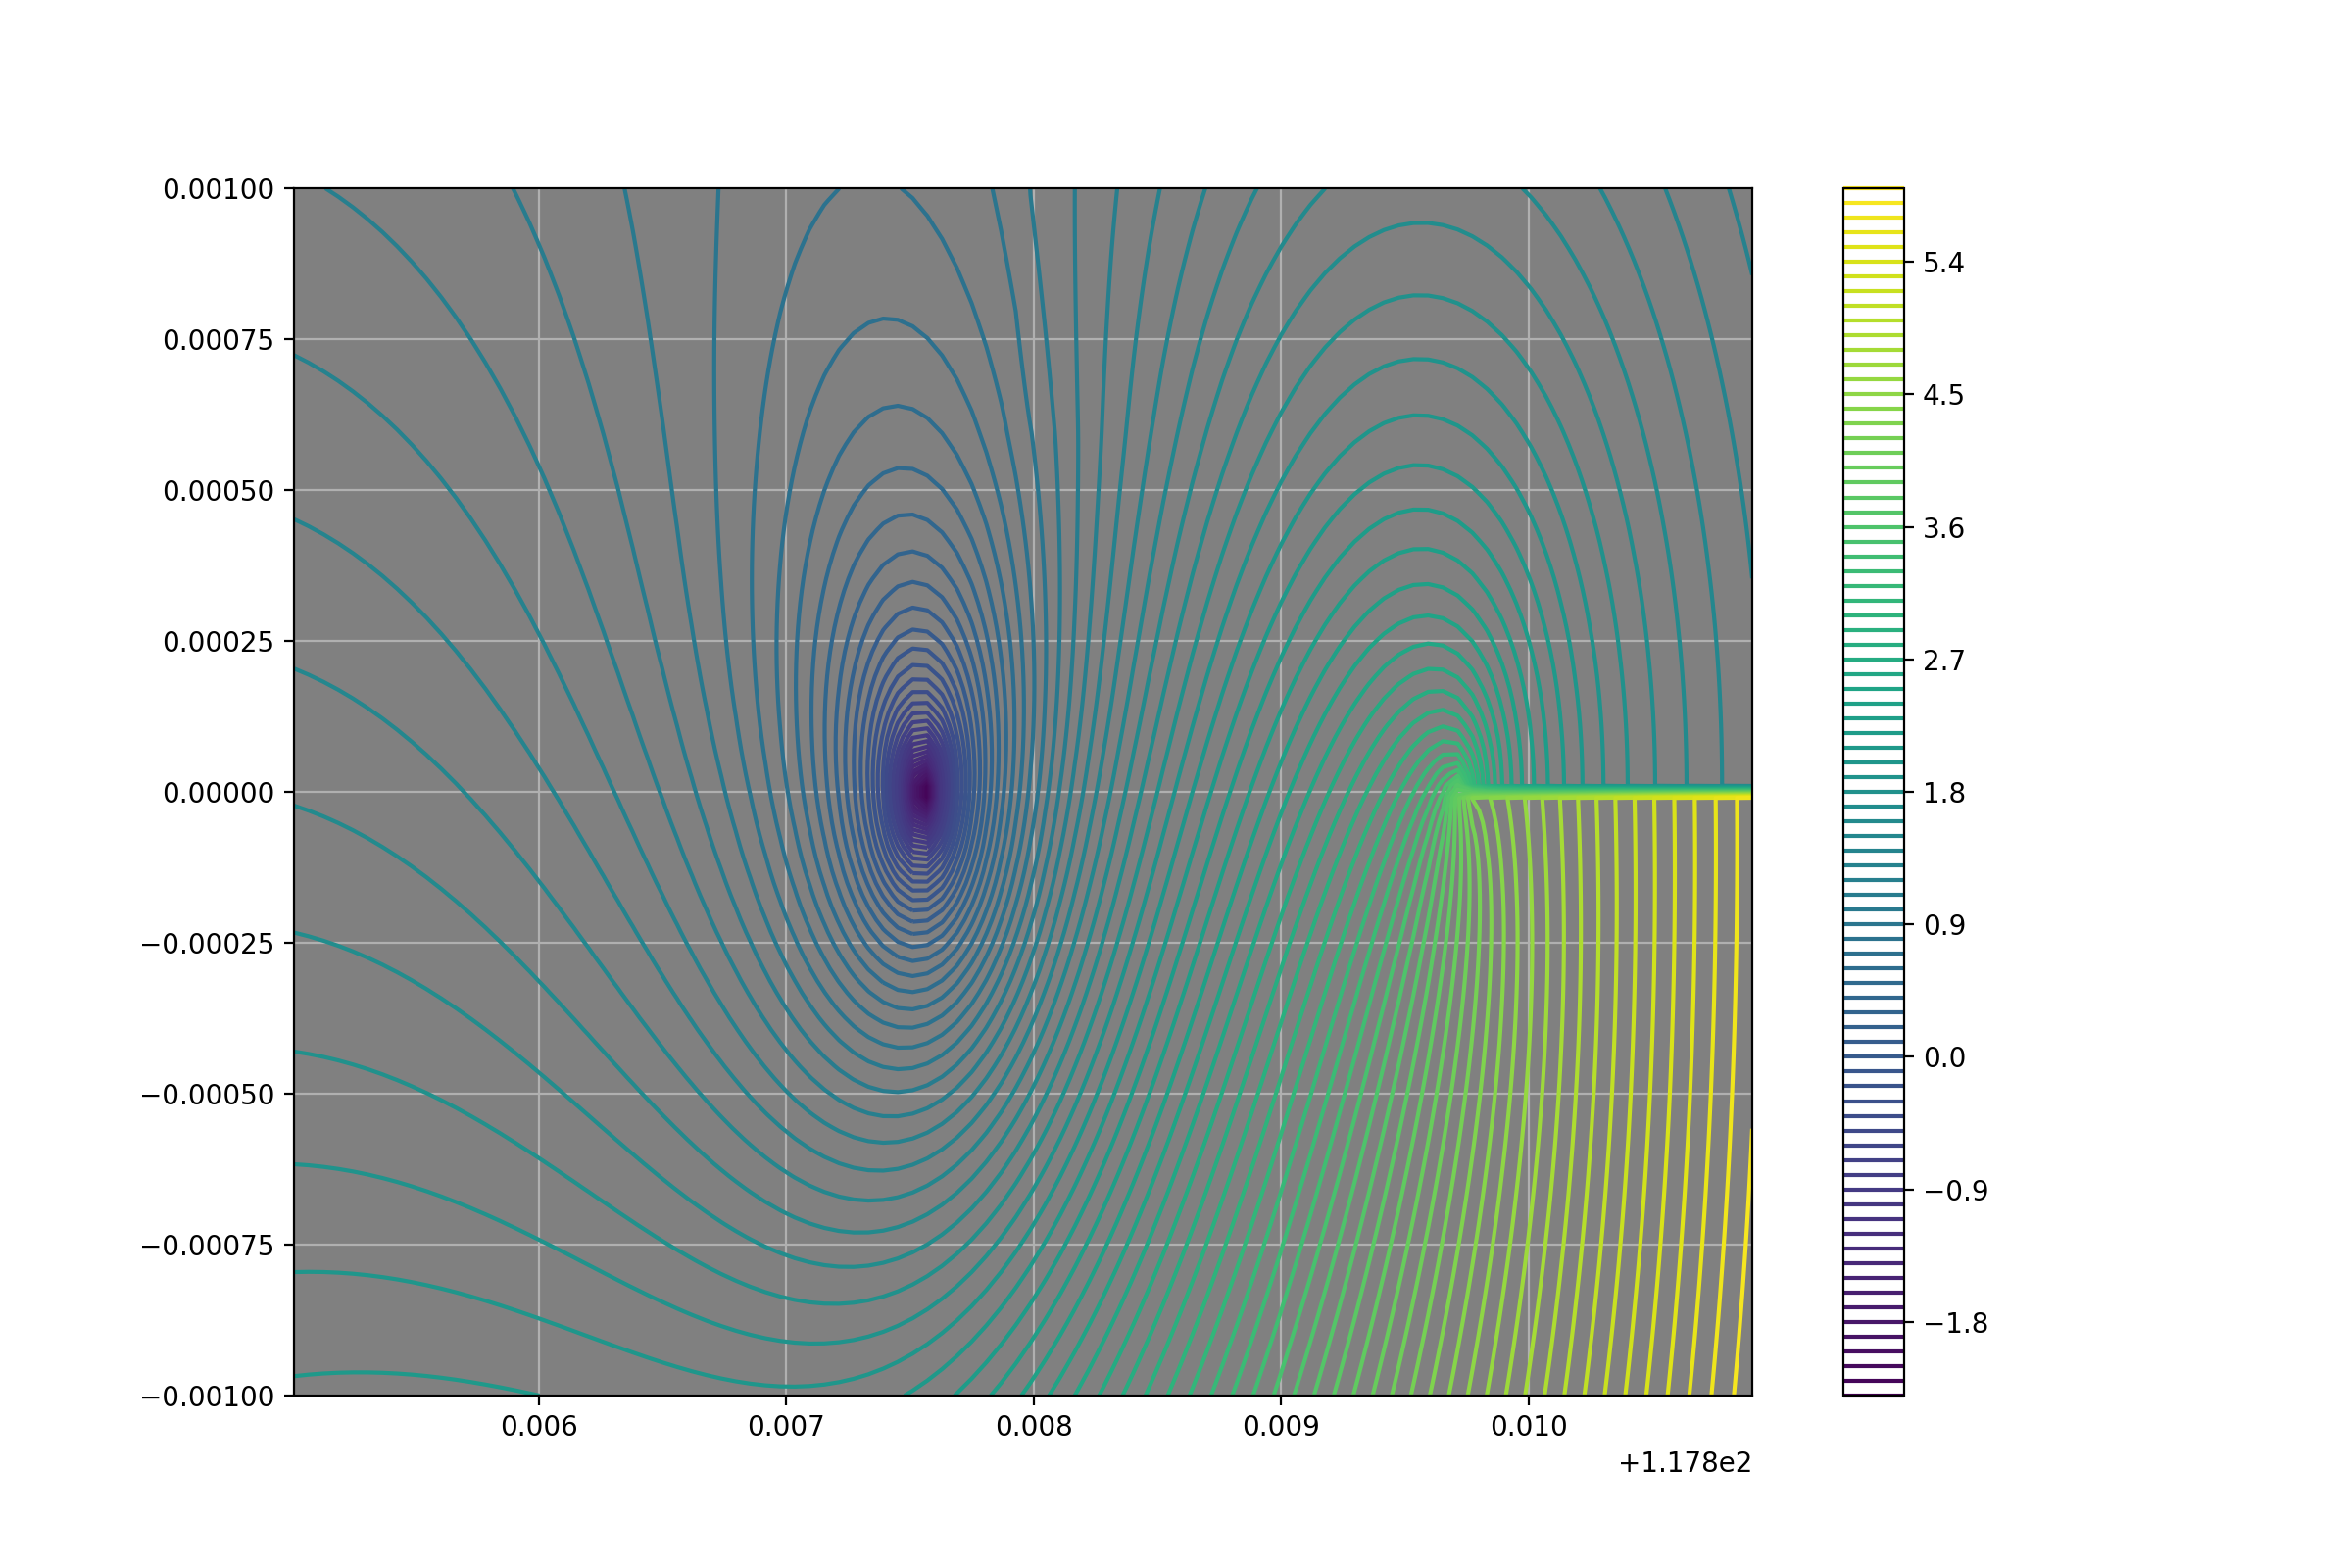

In [126]:
plotlogf(A.determinant,.99996*k_low,1.00001*k_low, -.001,.001, nu, outer, Ktype,
         iref=100, rref=100, levels=100)

In [127]:
guess = np.array(117.807)

beta1 = newton(A.determinant, guess, args=(nu, outer, Ktype), tol = 1e-15)

print("Scaled beta: ", beta1, ". Residual of determinant: ", abs(A.determinant(beta1, nu, outer, Ktype)))


Scaled beta:  (117.80755000321307-7.15506602945544e-07j) . Residual of determinant:  5.749259446773809e-11


# Bragg Scalar Function

In [128]:
U = A.all_fields(beta1, nu, outer, Ktype)

In [129]:
Draw(1e1*U, A.mesh, min=-3, max=10)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

In [133]:
ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_air,  lambda x:n_air]

ts = [5e-05, 1e-5, 5e-05, 5e-05]

mats = ['air', 'glass', 'air', 'Outer']

maxhs = [.1,.02, .1, .1]
B = Bragg(ts=ts, mats=mats, ns=ns, maxhs=maxhs, wl=.8e-6)


ModeSolver: Checking if mesh has required regions
Mesh has  10082  elements,  5072  points,  and  15153  edges.


In [134]:
Z = B.sqrZfrom

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

### Electric

In [112]:
u = A.fields_matplot(beta1, nu, outer)

<IPython.core.display.Javascript object>


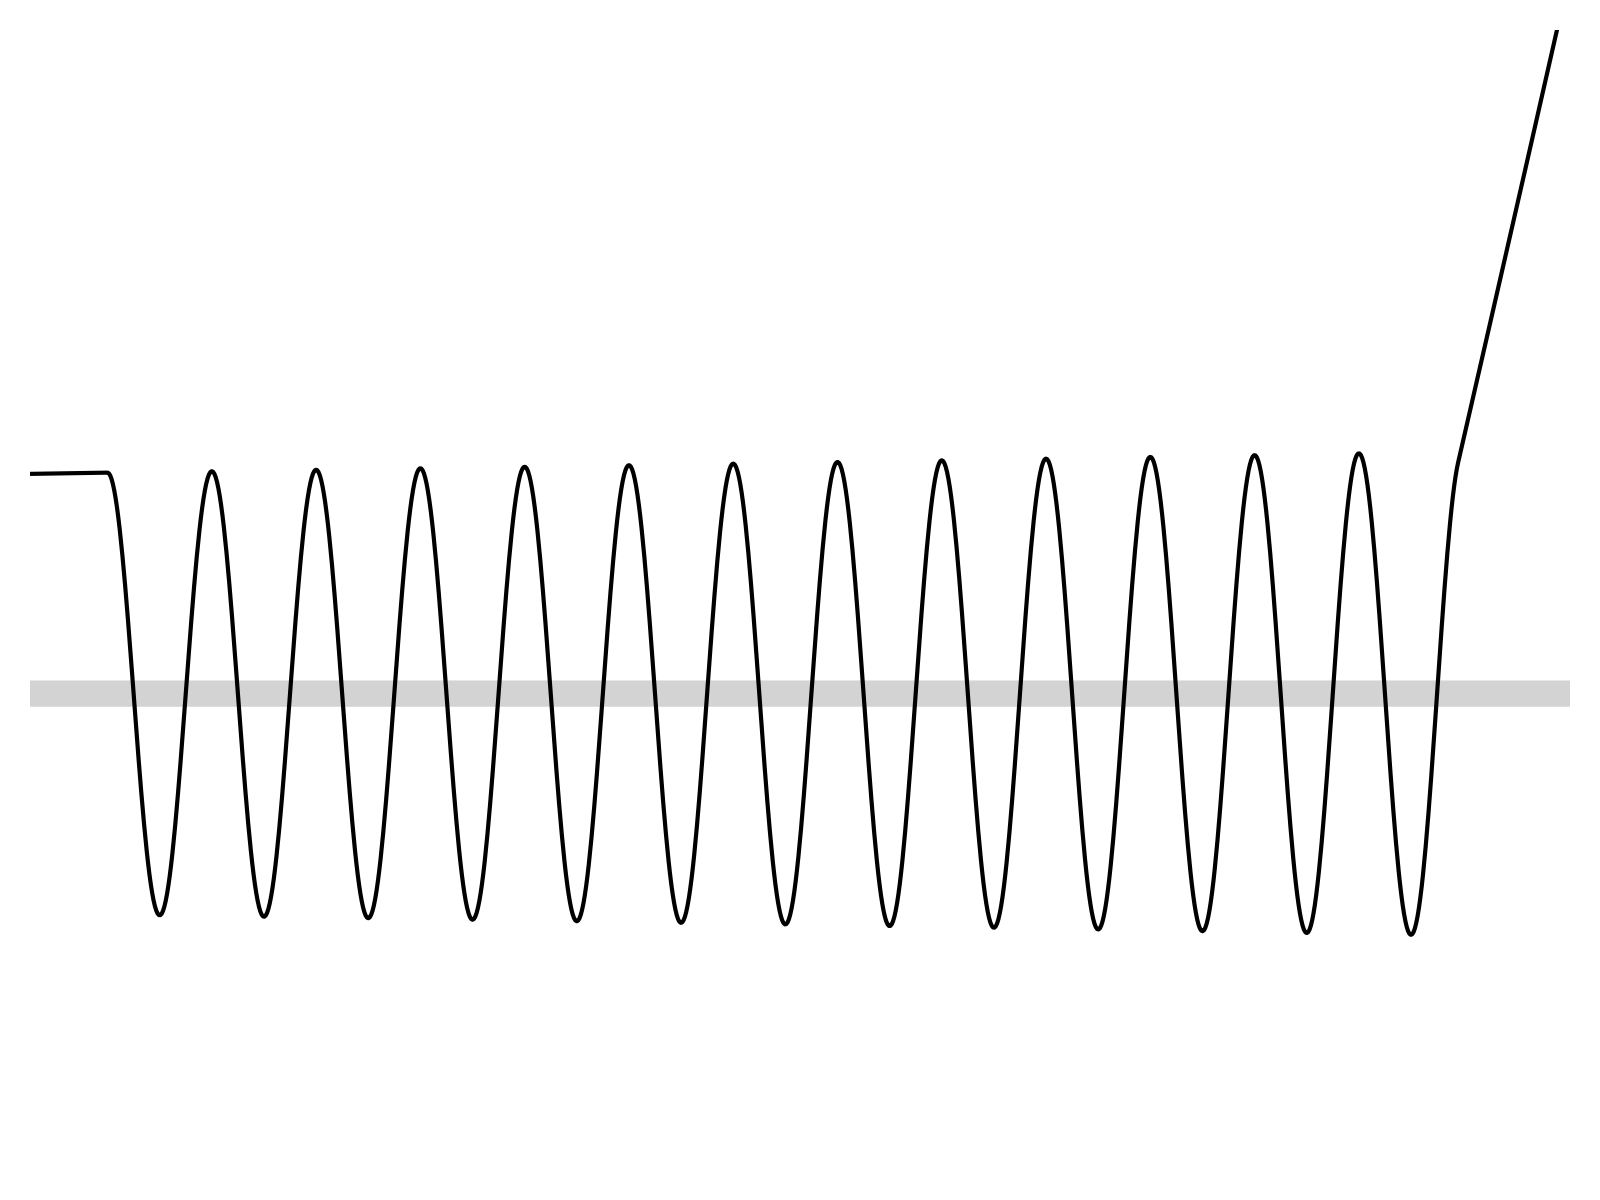

In [113]:
%matplotlib notebook
fig, ax = A.plot1D(u['Ez_rad'], double_r=True, rlist=[400,1000,400], nu=nu, maxscale=True,
                  linewidth=1.5, color='k')
Rhos = A.rhos/A.scale

ax.arrow(0,0, Rhos[-1], 0, color='lightgray', width=.001, 
         head_width=.03, head_length=.1)
ax.arrow(0,0, -Rhos[-1], 0, color='lightgray', width=.001, 
         head_width=.03, head_length=.1)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
m, M = ax.get_ylim()
# for r in Rhos:
#     ax.plot([r,r], [m, M], 'orange', linewidth=1.2, linestyle=':')
#     ax.plot([-r,-r], [m, M], 'orange', linewidth=1.2, linestyle=':')
ax.set_xlabel('\nDistance from Fiber Center')
fig.savefig('/home/pv/papers/outer_materials/figures/images/jpgs/1dlong.jpg')

# Resonant mode

In [3]:
# Formula for loss spikes from article

ms = np.arange(11,15,1)

n1 = A.ns[0]  # Inner (core) index
n2 = A.ns[1]  # Cladding index

d = 15*2/3*1e-6

ls = (2 * n1 * d / ms * ((n2/n1)**2 - 1)**.5)  # when n2 depends on ls, need solver
ls

NameError: name 'A' is not defined

In [4]:
wl_res= 1.592e-06

In [5]:
n_air = 1.00027717
n_glass = 1.4388164768221814

ns = [lambda x:n_air, lambda x:n_glass, lambda x:n_air]

ts = [4.0775e-05, 1e-5, 4.0775e-05]

mats = ['air', 'glass', 'air']

maxhs = [.1,.015, .1]

In [6]:
B = BraggExact(ts=ts, mats=mats, ns=ns, maxhs=maxhs, wl=wl_res)



In [7]:
k_low = B.k0 * B.ns[0] * B.scale
k_low

59.21727529193949

In [8]:
outer = 'h2'
nu = 1

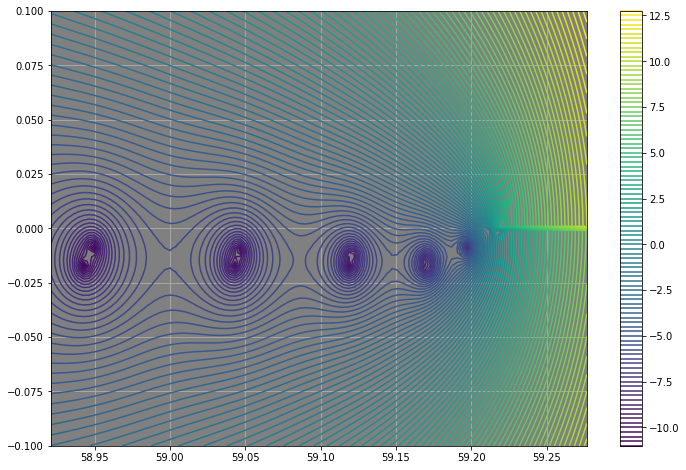

In [9]:
plotlogf(B.determinant, .995*k_low, 1.001*k_low, -.1,.1, nu, outer,
         iref=100, rref=100, levels=100)

In [10]:
guess = np.array(.9999 * k_low)

beta1 = newton(B.determinant, guess, args=(nu, outer), tol = 1e-15)

print("Scaled beta: ", beta1, ". Residual of determinant: ", abs(B.determinant(beta1, nu, outer)))


Scaled beta:  (59.1972401796462-0.00791219509033763j) . Residual of determinant:  1.4672014611063033e-15


# Bragg Exact Fields

In [11]:
FsB = B.all_fields(beta1, nu, outer)

### Electric

In [13]:
Draw(FsB['Ez'], B.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

In [14]:
fsB = B.fields_matplot(beta1, nu, outer)

<IPython.core.display.Javascript object>


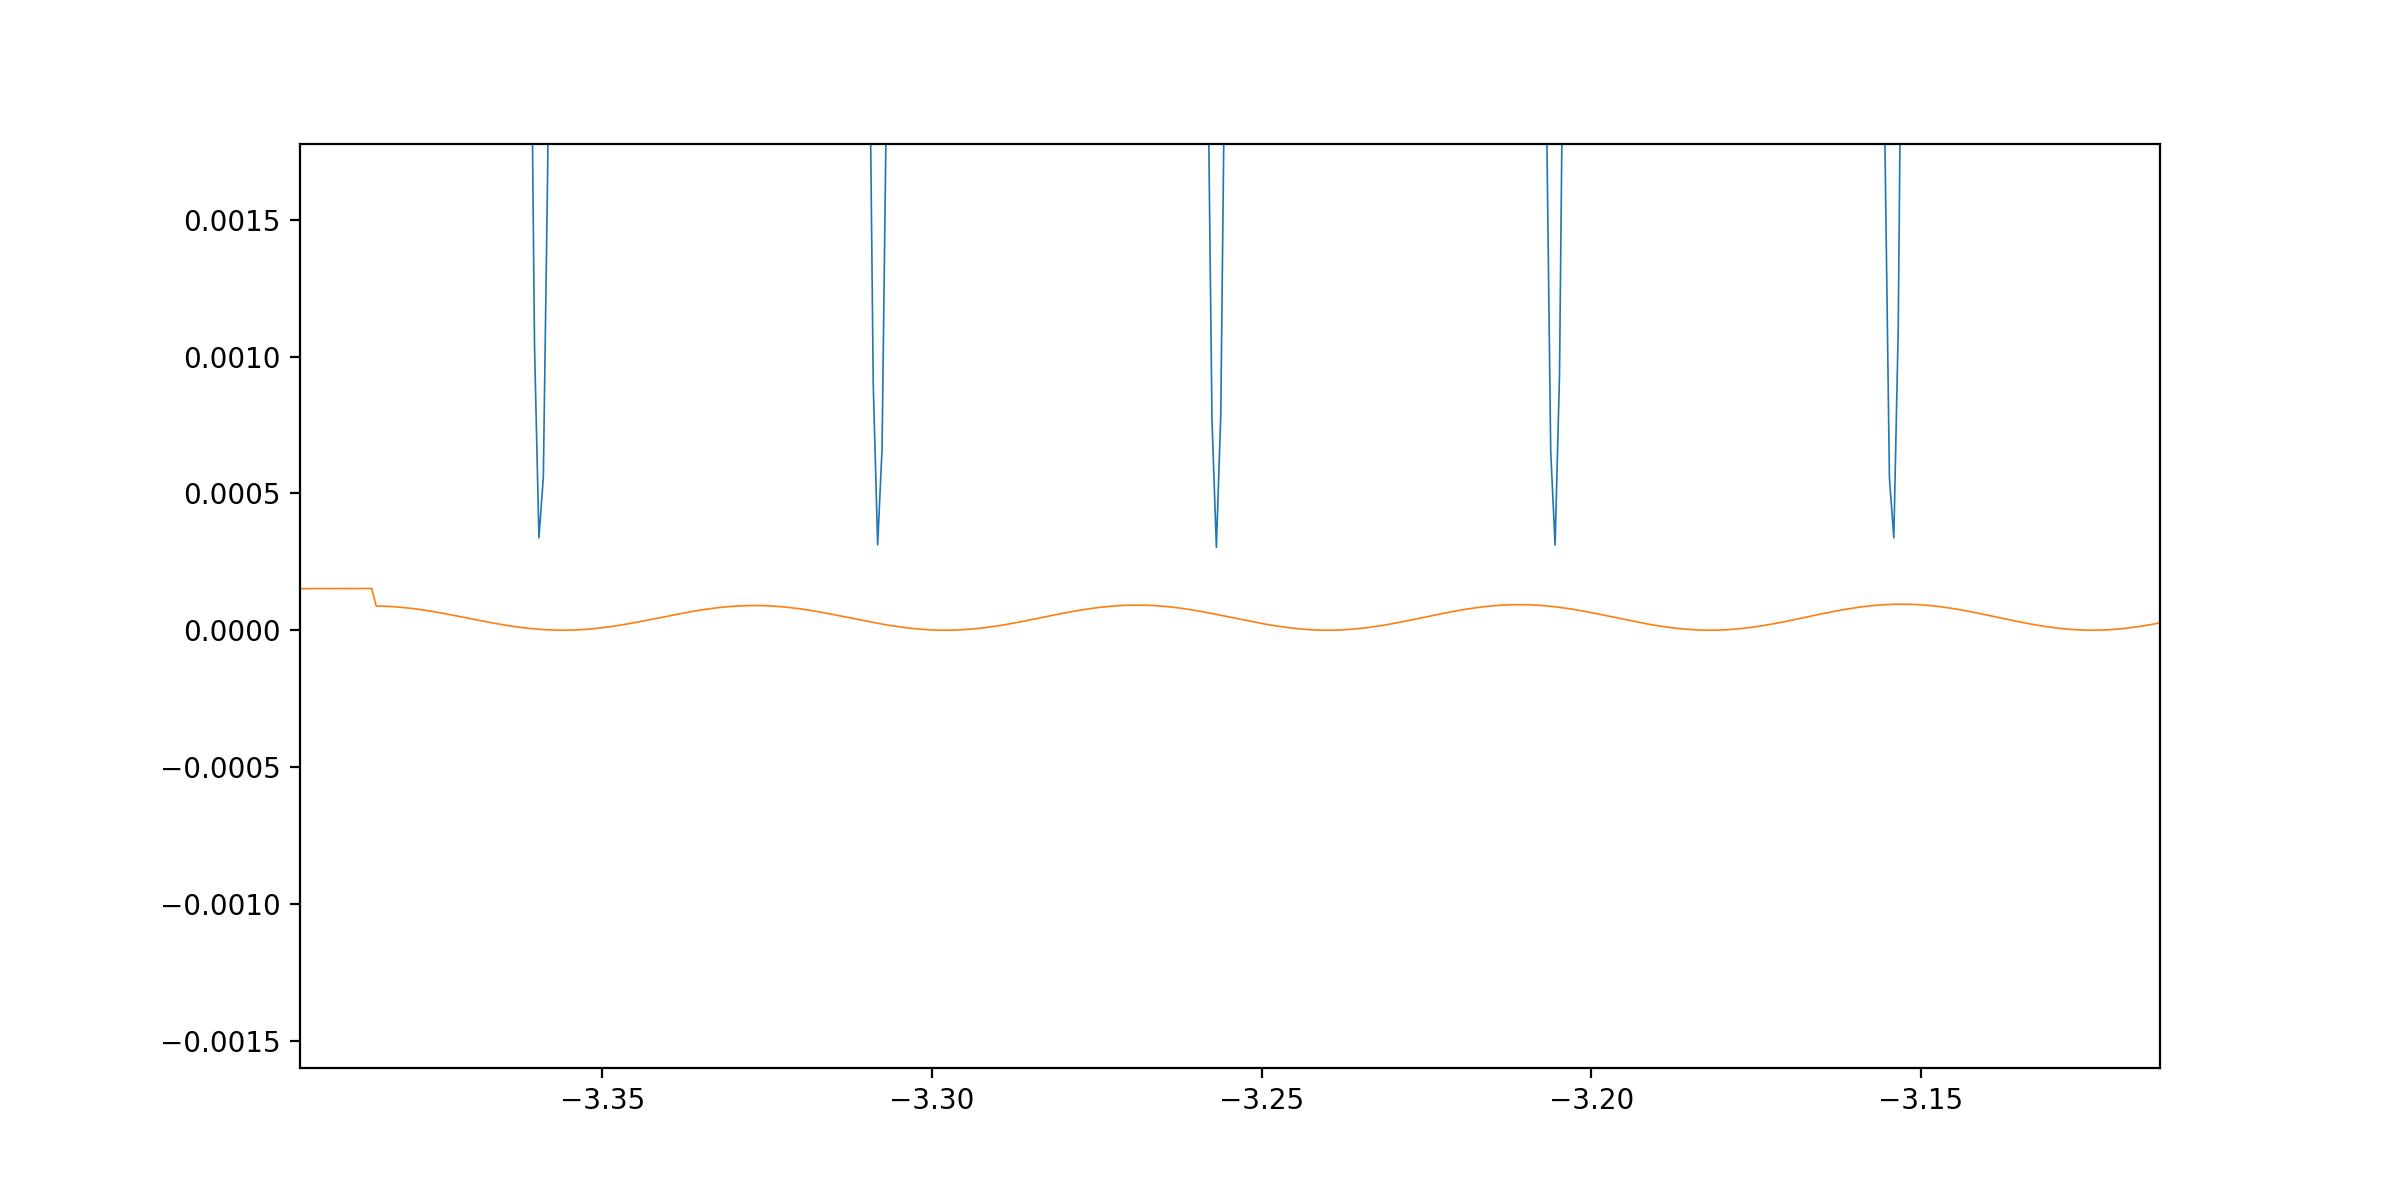

In [27]:
%matplotlib notebook
figsize=(12,6)
fig, ax = B.plot1D(fsB['Sz_rad'], double_r=True, rlist=[400,1000,400], nu=nu, 
                   part='norm', maxscale=True, figsize=figsize, linewidth=.6)
B.add1D_plot(ax, fsA['Sz_rad'], double_r=True,  nu=nu, part='norm', maxscale=True, linewidth=.6)

In [59]:
Draw(FsB['Sphi'], A.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene